In [1]:
import pathlib
import os, sys
import numpy as np
from loguru import logger
from collections import defaultdict
from openset_imagenet.util import ccr_at_fpr
import openset_imagenet
from matplotlib import pyplot

In [2]:
def load_scores(args):
    # we sort them as follows: protocol, loss, algorithm
    scores = defaultdict(lambda: defaultdict(dict))
    ground_truths = {}
    for i in range (4, 127):
        for net in ["random", "hamming"]:
                score_file = f"bce_binary_ensemble_combined_emnist_test_arr_curr_{net}_{i}.npz"
                if os.path.exists(score_file):
                    # remember files
                    results = np.load(score_file)
                    scores[score_file] = results["scores"] # only change in maxlogits case

                    if len(ground_truths) == 0:
                        ground_truths = results["gt"].astype(int)
                    else:
                        assert np.all(results["gt"] == ground_truths)

                    logger.info(f"Loaded score file {score_file} for net {net}")
                else:
                    logger.warning(f"Did not find score file {score_file} for net {net}")

    return scores, ground_truths

In [3]:
THRESHOLDS = {
              1e-3: "$10^{-3}$",
              1e-2: "$10^{-2}$",
              1e-1: "$10^{-1}$",
              1: "$1$",
}

scores, ground_truths = load_scores(None)
random_ccrs = []
hamming_ccrs = []
# we get ccr@fpr for each network
for i in range (4, 127):
    for net in ["random", "hamming"]:
        full_net = f"bce_binary_ensemble_combined_emnist_test_arr_curr_{net}_{i}.npz"
        ccrs = ccr_at_fpr(ground_truths, scores[full_net], THRESHOLDS)
        ccrs_sum = 0
        for ccr in ccrs:
            if type(ccr) != type(None):
                ccrs_sum += ccr
        if net == "random":
            random_ccrs.append(ccrs_sum)
        else:
            hamming_ccrs.append(ccrs_sum)
        logger.info(f"Network {full_net}: {ccrs_sum} for thresholds {THRESHOLDS.values()}")

2024-05-16 08:48:21.706 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_random_4.npz for net random
2024-05-16 08:48:21.710 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_hamming_4.npz for net hamming
2024-05-16 08:48:21.714 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_random_5.npz for net random
2024-05-16 08:48:21.717 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_hamming_5.npz for net hamming
2024-05-16 08:48:21.721 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_random_6.npz for net random
2024-05-16 08:48:21.725 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_hamming_6.npz for net hamming
2024-05-16 08:48:21.729 | INFO     | __m

In [4]:
print(hamming_ccrs)
print(random_ccrs)

[1.5346, 1.5072, 1.4987, 1.491, 1.5024, 1.4990999999999999, 1.5030999999999999, 1.5028000000000001, 1.4942, 1.5021, 1.5049000000000001, 1.5027, 1.5055, 1.5026000000000002, 1.496, 1.4994, 1.5087000000000002, 1.5049000000000001, 1.501, 1.501, 1.4977, 1.4954, 1.4994, 1.5017999999999998, 1.4978, 1.496, 1.4999, 1.4987, 1.5006, 1.4992999999999999, 1.4974, 1.4961, 1.4935, 1.4956999999999998, 1.5024, 1.5042, 1.5038, 1.5048, 1.5013, 1.5011, 1.4998999999999998, 1.4998, 1.4999000000000002, 1.5006, 1.5044, 1.5055, 1.5051999999999999, 1.5034, 1.5072999999999999, 1.5068, 1.5078, 1.5097, 1.5106000000000002, 1.5076999999999998, 1.5106, 1.5076999999999998, 1.5069, 1.5064, 1.5051999999999999, 1.5064, 1.5081, 1.5077, 1.5085, 1.5141999999999998, 1.5146, 1.5116999999999998, 1.5114999999999998, 1.5114999999999998, 1.5118, 1.5127000000000002, 1.5106000000000002, 1.5097999999999998, 1.5106000000000002, 1.5095999999999998, 1.5111, 1.5095, 1.5120999999999998, 1.5133999999999999, 1.5125, 1.5104, 1.51189999999999

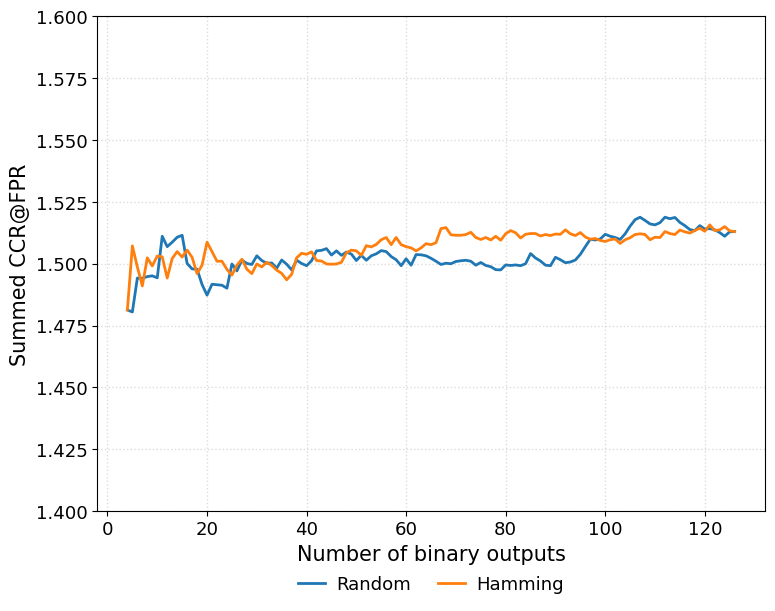

In [8]:
import matplotlib.pyplot as plt

# Set font properties
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15}
plt.rc('font', **font)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data
ax.plot(range(4, 127), random_ccrs, label="Random", linewidth=2)
ax.plot(range(4, 127), hamming_ccrs, label="Hamming", linewidth=2)

# Set axis labels
ax.set_xlabel('Number of binary outputs', fontsize=15)
ax.set_ylabel('Summed CCR@FPR', fontsize=15)

# Set y-axis range from 0 to 4
ax.set_ylim(1.4, 1.6)

# Set grid properties
ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
ax.grid(axis='y', linestyle=':', linewidth=1, color='gainsboro')

# Set axis ticks
ax.tick_params(axis='both', which='major', labelsize=13)

# Adjust layout
plt.tight_layout()

# Set legend below the plot
plt.legend(frameon=False, fontsize=13, handlelength=1.5, handletextpad=0.6, columnspacing=1.5, loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=2)

# Display the plot
plt.savefig("ex_1_ccr_fpr.pdf", bbox_inches='tight')
plt.show()